In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)


In [2]:
data

Data(edge_index=[2, 4], x=[3, 1])

In [3]:
print(data['edge_index'])

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [4]:
device = torch.device('cuda')
data = data.to(device)

In [5]:
edge_index = torch.tensor([[0, 1, 0, 2, 0, 3, 0, 4],
                           [1, 0, 2, 0, 3, 0, 4, 0]], dtype=torch.long)
x = torch.tensor([[2, 2], [0, 0], [0, 4], [4, 0], [4, 4]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [6]:
import random

def sim_body_position():
    x = 2 + random.random()/2
    y = 2 + random.random()/2
    return [x, y]

def sim_left_wing(seq):
    x_up = 0 + random.random()/2
    x_bottom = 0 + random.random()/2
    state = 2 - abs(seq - 2)
    y_up = 4 - state + random.random()/2
    y_bottom = state + random.random()/2
    return [[x_bottom, y_bottom], [x_up, y_up]]

def sim_right_wing(seq):
    x_up = 4 + random.random()/2
    x_bottom = 4 + random.random()/2
    state = 2 - abs(seq - 2)
    y_up = 4 - state + random.random()/2
    y_bottom = state + random.random()/2
    return [[x_bottom, y_bottom], [x_up, y_up]]

    

In [7]:
def simulate_5_node_frame(seq, label):
    positions = []
    positions.append(sim_body_position())
    left = sim_left_wing(seq%5)
    positions.append(left[0])
    positions.append(left[1])
    right = sim_right_wing((seq+(label*2))%5)
    positions.append(right[0])
    positions.append(right[1])
    return positions


In [8]:
print(simulate_5_node_frame(0,1))

[[2.421285124891745, 2.325956110212554], [0.42840273455554007, 0.06785141521087362], [0.4495365461277875, 4.018021062211995], [4.431344816379576, 2.121564381833105], [4.06895212601453, 2.130408274925909]]


In [9]:
def simulate_5_node_activity(size, label):
    frames = []
    for i in range(size):
        frame = simulate_5_node_frame(i, label)
        frames.append(frame)
    return frames

In [10]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_function(i, ag):
    colors = [[1,0,0],[0,0.5,0],[0,0.8,0.8],[0.8,0.8,0],[0,0,1]]
    ax.clear()
    ax.axis([-0.5,5.5,-0.5,5.5])
    frames = ag.get_frames_as_tensor()
    for edge_index in range(ag.get_num_edges()):
        s, t = ag.get_edge(edge_index)
        s_pos = ag.get_node_data(i,s)
        t_pos = ag.get_node_data(i,t)
        line = plt.Line2D((s_pos[0],t_pos[0]), (s_pos[1],t_pos[1]))
        ax.add_artist(line)
    for node_index in range(ag.num_nodes):
        pos = ag.get_node_data(i, node_index)
        circle = plt.Circle((pos[0], pos[1]), 0.2, color=colors[node_index])
        ax.add_artist(circle)

def animate_activity_graph(activity_graph):
    ani = matplotlib.animation.FuncAnimation(fig, animate_function, fargs=(activity_graph,), frames=len(activity_graph.frames))
    return ani
        

In [11]:
      
class ActivityGraph(object):
    def __init__(self, edge_index, num_nodes, label):
        self.edge_index = edge_index
        self.num_nodes = num_nodes
        self.label = label
        self.frames = []
        
    def add_data_frame(self, data_frame):
        self.frames.append(data_frame.tolist())
        
    def get_frames_as_tensor(self):
        return torch.tensor(self.frames, dtype=torch.float)
    
    def get_animation(self):
        return animate_activity_graph(self)
    
    def get_num_edges(self):
        return len(self.edge_index.t())
    
    def get_edge(self, index):
        s = self.edge_index.t()[index][0].item()
        t = self.edge_index.t()[index][1].item()
        return s, t
    
    def get_node_data(self, frame, node):
        return self.frames[frame][node]
    
    def to_geometric_data(self):
        s = []
        t = []
        f = []
        for i in range(len(self.frames)):
            s = s + ((edge_index[0]+(i*self.num_nodes)).tolist()) 
            t = t + ((edge_index[1]+(i*self.num_nodes)).tolist())
            if (i>0):
                for j in range(self.num_nodes):
                    a = i*self.num_nodes + j
                    b = (i-1)*self.num_nodes + j
                    s = s + [a, b]
                    t = t + [b, a]
        g_edge_index = torch.tensor([s, t], dtype=torch.long)
        
        for i in range(len(self.frames)):
            for j in range(self.num_nodes):
                f.append(self.frames[i][j])
        x = torch.tensor(f, dtype=torch.float)
        data = Data(x=x, edge_index=g_edge_index, y=self.label)
        return data
        

    def plot(self):
        print(self.edge_index)

In [12]:
def create_simulation(label, lenght):
    a = ActivityGraph(edge_index, 5, label)
    for frame in simulate_5_node_activity(lenght, label):
        f = torch.tensor(frame, dtype=torch.float)
        a.add_data_frame(f)
    return a

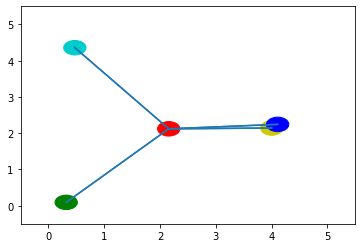

In [13]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
a = create_simulation(1, 20)

fig = plt.figure()
ax = plt.axes()
ani = a.get_animation()
HTML(ani.to_jshtml())  

In [14]:
from pythreejs import *
from IPython.display import display
from math import pi

In [15]:
class ActivityGraphRendererBuilder(object):
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes
        self.scene_children = []
        self.camera = self.create_camera()
        self.add_light()
        self.scene_children.append(self.camera)
        self.colors = ['#27AE60', '#3498DB','#E74C3C',
                       '#6C3483','#2874A6','#1E8449','#B7950B','#A04000','#F1C40F',
                       '#D2B4DE','#A3E4D7','#AED6F1','#F9E79F','#E6B0AA','#922B21']
        
    def add_geom_data(self, geom_data):
        nodes = a.to_geometric_data()['x']
        edges = a.to_geometric_data()['edge_index']
        self.add_nodes(nodes)
        self.add_edges(edges, nodes)

        
    def add_nodes(self, nodes):
        for i in range(len(nodes)):
            frame = int(i/self.num_nodes)
            color = self.colors[(i%self.num_nodes)]            
            self.scene_children.append(self.add_ball(nodes[i].tolist(), frame, color))
            
    def add_edges(self, edges, nodes):
        e = edges.t()
        for i in range(len(e)):
            idxs = e[i].tolist()
            s = idxs[0]
            t = idxs[1]
            pos_s = nodes[s]
            pos_t = nodes[t]
            frame_s = int(s/self.num_nodes)
            frame_t = int(t/self.num_nodes)
            g2 = LineSegmentsGeometry(positions=[[[pos_s[0], pos_s[1], frame_s], [pos_t[0], pos_t[1], frame_t]]],)
            m2 = LineMaterial(linewidth=3, color='black')
            line = LineSegments2(g2, m2)
            self.scene_children.append(line)
            
            
            
            
    def add_ball(self, pos, frame, color):
        ball = Mesh(geometry=SphereGeometry(), 
             material=MeshLambertMaterial(color=color),
             position=[pos[0], pos[1], frame ],
             scale=[.2,.2,.2])
        return ball
            
    def add_light(self):    
        self.scene_children.append(AmbientLight(color='#777777'))
        
    def create_camera(self):
        key_light = DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)
        c = PerspectiveCamera(position=[0, 5, 5], up=[0, 1, 0], children=[key_light])
        return c
        
        
    def build_renderer(self):                
        scene = Scene(children=self.scene_children, background=None)

        return Renderer(camera=self.camera, 
                    scene=scene,
                    alpha=True,
                    clearOpacity=0,
                    controls=[OrbitControls(controlling=self.camera)],
                    width=800,
                    height=600)
        

In [16]:
x = a.to_geometric_data()['x']
edges = a.to_geometric_data()['edge_index']
agrb = ActivityGraphRendererBuilder(a.num_nodes)
agrb.add_geom_data(a.to_geometric_data())
display(agrb.build_renderer())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [17]:
from torch_geometric.data import Batch
def generate_batch():
    data_list = []
    for i in range(128):
        a = create_simulation(random.choice([0,1]), 20)
        data_list.append(a.to_geometric_data())
    return Batch.from_data_list(data_list)

In [18]:
batch = generate_batch()

batch.num_graphs

128

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv
from torch_scatter import scatter_mean

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ChebConv(2, 8, 3)
        self.conv2 = ChebConv(8, 2, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
            x = scatter_mean(x, data.batch, dim=0)
        return F.log_softmax(x, dim=1)

[199999/200000] Loss: 0.0007 / Acc: 0.9922


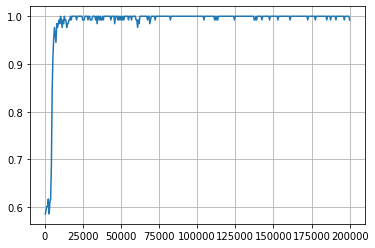

In [20]:
from IPython.display import clear_output, display

device = torch.device('cuda')
model = Net().to(device)
data = generate_batch()
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
epochs = 200000
model.train()
acc_history = []
epoch_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    # print(out.shape)
    # loss = F.nll_loss(out, data.y)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
    if (epoch + 1) % 500 == 0:
        _, pred = model(data).max(dim=1)
        correct = float (pred.eq(data.y).sum().item())
        acc = correct / data.num_graphs
        acc_history.append(acc)
        epoch_history.append(epoch)
        clear_output(wait=True)
        
        print('[{}/{}] Loss: {:.4f} / Acc: {:.4f}'.format(epoch, epochs, total_loss, acc))
        fig, ax = plt.subplots()
        ax.plot(epoch_history, acc_history)
        ax.grid()       
        plt.show()
    

In [312]:
model.eval()
data = generate_batch()
data = data.to(device)
_, pred = model(data).max(dim=1)
correct = float (pred.eq(data.y).sum().item())
acc = correct / data.num_graphs
print(model(data))
print('Accuracy: {:.4f}'.format(acc))
print(model(data).max(dim=1).indices)
print(data.y)

tensor([[-4.0830e+00, -1.7001e-02],
        [-4.2550e+00, -1.4295e-02],
        [-3.8092e+00, -2.2415e-02],
        [ 0.0000e+00, -5.1431e+01],
        [-4.0534e+00, -1.7515e-02],
        [ 0.0000e+00, -5.4971e+01],
        [-3.9300e+00, -1.9840e-02],
        [-4.3085e+00, -1.3545e-02],
        [-4.5594e+00, -1.0523e-02],
        [ 0.0000e+00, -4.8225e+01],
        [ 0.0000e+00, -4.8188e+01],
        [-4.4049e+00, -1.2292e-02],
        [ 0.0000e+00, -5.2878e+01],
        [ 0.0000e+00, -5.3490e+01],
        [-3.7699e+00, -2.3325e-02],
        [ 0.0000e+00, -5.2021e+01],
        [ 0.0000e+00, -4.9715e+01],
        [ 0.0000e+00, -7.6887e+01],
        [-3.7881e+00, -2.2898e-02],
        [-4.7165e+00, -8.9869e-03],
        [ 0.0000e+00, -5.0051e+01],
        [-4.3939e+00, -1.2429e-02],
        [ 0.0000e+00, -4.8703e+01],
        [-5.2273e+00, -5.3823e-03],
        [ 0.0000e+00, -7.1718e+01],
        [-3.8076e+00, -2.2451e-02],
        [-4.2786e+00, -1.3958e-02],
        [-4.5158e+00, -1.099